# Downloading data

In [1]:
import torch

# Other files
import utils
from models.autowarp import AutoWarp
from models.mean_variance_optimisation import MeanVarianceOptimisation
from models.autoencoders import LinearAutoencoder, ConvAutoencoder, ConvLinearAutoEncoder, train_autoencoder, get_distance_matrix

# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Optimisation
from pypfopt.expected_returns import mean_historical_return

import yfinance as yf

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0);

C:\Users\roryc\miniconda3\envs\metric_learning_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
# 2 years training (split into 1 year train and 1 year valid), 18 months test
start_date = '2017-06-01'
valid_date = '2018-06-01'
train_date = '2019-06-01'
end_date   = '2021-01-01'

prices_train, _, _, prices_test = utils.split_prices(start_date=start_date, valid_date=valid_date, train_date=train_date, end_date=end_date, train_number=200)
data_train, _ = utils.split_orbis_data(start_date=start_date, valid_date=valid_date, train_date=train_date, returns=True, momentum=True, train_number=200)

In [6]:
import datetime
from dateutil.relativedelta import relativedelta
date_format = "%Y-%m-%d"

In [7]:
start_dates = ['2017-03-01', '2017-09-01', '2018-03-01', '2018-09-01', '2019-03-01']
date_format = "%Y-%m-%d"
start_dates = [datetime.datetime.strptime(date, date_format) for date in start_dates]
valid_dates = [date + relativedelta(years=1) for date in start_dates]
train_dates = [date + relativedelta(years=2) for date in start_dates]
end_dates = [date + relativedelta(years=3, months=6) for date in start_dates]

In [ ]:
from orbis_yf_data import download_all_data
sp500_ratios = pd.read_excel('data/S&P Ratios.xlsx', index_col=0, sheet_name="Results", usecols='C:CU')
download_all_data(sp500_ratios, start_dates[0])

In [5]:
# S&P 500
sp500 = yf.download("^GSPC", start=train_date, end=end_date, period="1d")['Adj Close']
sp500 = sp500.div(sp500.iloc[0]).mul(100)

[*********************100%***********************]  1 of 1 completed


In [9]:
# Dict for matrices
params = {'Linear': {}, 'CNN': {}, 'Linear + CNN': {}}

params['Linear']['autoencoder'] = {'latent_size': 41, 'hidden_size': 201, 'batch_size': 21}
params['Linear']['dist_matrix'] = {'latent_size': 41, 'p': 0.5, 'max_iterations': 50, 'batch_size': 25, 'lr': 0.01}
params['Linear']['risk_matrix'] = {'C': -0.45062589027080474}

params['CNN']['autoencoder'] = {'latent_size': 38, 'hidden_size': 292, 'batch_size': 27}
params['CNN']['dist_matrix'] = {'latent_size': 38, 'p': 0.5, 'max_iterations': 50, 'batch_size': 25, 'lr': 0.01}
params['CNN']['risk_matrix'] = {'C': -0.41643980400603453}

params['Linear + CNN']['autoencoder'] = {'latent_size': 37, 'hidden_size': 265, 'hidden_size2': 211, 'batch_size': 23}
params['Linear + CNN']['dist_matrix'] = {'latent_size': 37, 'p': 0.5, 'max_iterations': 50, 'batch_size': 25, 'lr': 0.01}
params['Linear + CNN']['risk_matrix'] = {'C': -0.4728019352074843}

num_epochs=20

# Calculating distance matrix

In [7]:
models = {}
models['Linear'] = train_autoencoder(LinearAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear']['autoencoder'])
models['CNN'] = train_autoencoder(ConvAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['CNN']['autoencoder'])
models['Linear + CNN'] =train_autoencoder(ConvLinearAutoEncoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear + CNN']['autoencoder'])

LinearAutoencoder
Epoch [1/20], Loss: 0.0966
Epoch [2/20], Loss: 0.0218
Epoch [3/20], Loss: 0.0172
Epoch [4/20], Loss: 0.0153
Epoch [5/20], Loss: 0.0145
Epoch [6/20], Loss: 0.0140
Epoch [7/20], Loss: 0.0134
Epoch [8/20], Loss: 0.0128
Epoch [9/20], Loss: 0.0118
Epoch [10/20], Loss: 0.0110
Epoch [11/20], Loss: 0.0103
Epoch [12/20], Loss: 0.0097
Epoch [13/20], Loss: 0.0091
Epoch [14/20], Loss: 0.0087
Epoch [15/20], Loss: 0.0084
Epoch [16/20], Loss: 0.0082
Epoch [17/20], Loss: 0.0079
Epoch [18/20], Loss: 0.0078
Epoch [19/20], Loss: 0.0076
Epoch [20/20], Loss: 0.0075
ConvAutoencoder
Epoch [1/20], Loss: 0.1147
Epoch [2/20], Loss: 0.0821
Epoch [3/20], Loss: 0.0523
Epoch [4/20], Loss: 0.0321
Epoch [5/20], Loss: 0.0219
Epoch [6/20], Loss: 0.0163
Epoch [7/20], Loss: 0.0132
Epoch [8/20], Loss: 0.0117
Epoch [9/20], Loss: 0.0111
Epoch [10/20], Loss: 0.0108
Epoch [11/20], Loss: 0.0106
Epoch [12/20], Loss: 0.0105
Epoch [13/20], Loss: 0.0103
Epoch [14/20], Loss: 0.0101
Epoch [15/20], Loss: 0.0100
Epoc

In [10]:
%%time
dist_matrices = {}
for model in ['Linear', 'Linear + CNN', 'CNN']:
    print(model)
    learner = AutoWarp(models[model], data_train, **params[model]['dist_matrix'])
    learner.learn_metric()
    dist_matrices[model] = learner.create_distance_matrix()

Linear
alpha:  0.8177229762077332
gamma:  0.7241237759590149
epsilon:  0.7650370001792908
betaCV:  0.6890694499015808
Linear + CNN
alpha:  0.7247654795646667
gamma:  0.7051586508750916
epsilon:  0.6658768057823181
betaCV:  0.7317968606948853
CNN
alpha:  0.7103754878044128
gamma:  0.6601576209068298
epsilon:  0.6238847970962524
betaCV:  0.5793282985687256
CPU times: total: 13min 21s
Wall time: 2min 50s


# Mean variance optimisation

In [11]:
# Empty dict for weights
weights = {}

#for model in ["Linear", "Linear + CNN"]:
for model in ["Linear", "CNN", "Linear + CNN"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    risk_matrix = optimiser.make_risk_matrix(dist_matrices[model], **params[model]['risk_matrix'])
    weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, train_sr)

#for model in ["Covariance", "Covariance Shrinkage", "Exponentially weighted Covariance"]:
for model in ["Covariance", "Covariance Shrinkage"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        risk_matrix = optimiser.benchmark_matrix(model)
        weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, train_sr)

# Equal weights
weights['Equal'] = weights['Linear'].copy()
weights['Equal']['weights'] = 1/weights['Linear']['weights'].shape[0]
print("Equal", utils.calculate_sharpe_ratio(weights=weights['Equal'], prices=prices_train))

Linear 1.8168129248659368
CNN 0.8128862964664987
Linear + CNN 0.8409723326675297
Covariance 2.3071289968259725
Covariance Shrinkage 2.306223463343968
Equal 0.6471620842146256


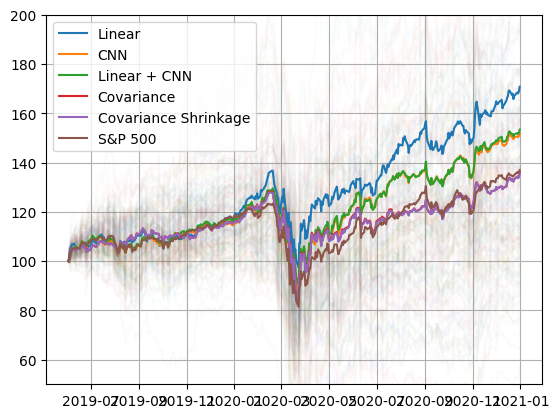

In [12]:
# Plots
plt.plot(prices_test, alpha=0.025)
#for model in ["Linear", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Equal"]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage"]:
    plt.plot(prices_test @ weights[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.grid()
plt.legend();

In [13]:
# Sharpe ratios
rf = 0.02

# for model in ["Linear", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Equal"]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Equal"]:
    print(model, "sharpe",  utils.calculate_sharpe_ratio(prices = prices_test, weights = weights[model]))
    #print(model, "std",utils.calculate_sd(prices = prices_test, weights = weights[model]))

sp500_returns =((sp500/sp500.shift(1))-1).dropna()
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    effr = pd.read_excel('data/EFFR.xlsx', sheet_name='Results', index_col=0, usecols='A:C', engine="openpyxl")
effr = effr.drop(columns='Rate Type', axis=1)
effr.index = pd.to_datetime(effr.index)
effr['Rate (%)'] = effr['Rate (%)'] / (100*252)

# Calculate excess returns
sp500_returns = pd.merge(sp500_returns, effr, how='left', left_index=True, right_index=True)
sp500_returns['Rate (%)'] = sp500_returns['Rate (%)'].fillna(method='ffill')
assert sp500_returns.isnull().sum().sum() == 0
sp500_returns['excess_returns'] = sp500_returns['Adj Close'] - sp500_returns['Rate (%)']

# Calculate Sharpe Ratio
avg_return = sp500_returns['excess_returns'].mean() * 252
std = sp500_returns['excess_returns'].std() * np.sqrt(252)
sharpe = avg_return / std
print("S&P 500", sharpe)

Linear sharpe 1.257094449495994
CNN sharpe 1.03551421041015
Linear + CNN sharpe 1.0702756885212208
Covariance sharpe 0.7729233207703627
Covariance Shrinkage sharpe 0.773141177487693
Equal sharpe 0.8199716600253122
S&P 500 0.8064283369099782


In [14]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage"]:
    print(model, "number of stocks included:", np.count_nonzero(weights[model]))

Linear number of stocks included: 12
CNN number of stocks included: 30
Linear + CNN number of stocks included: 37
Covariance number of stocks included: 17
Covariance Shrinkage number of stocks included: 18


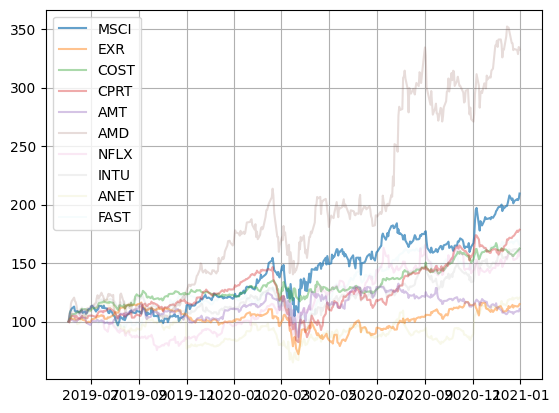

In [15]:
# Plot performance of Linear stocks
for i in weights['Linear'].sort_values(by='weights', ascending=False).head(10).index:
    plt.plot(prices_test[i], label=i, alpha=min(weights['Linear'].loc[i, 'weights']*3, 1))
plt.legend()
plt.grid();

# HRP

In [92]:
from models.hrp import HRPOpt
rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)
hrp.optimize(dist_matrix=dist_matrices['Linear'])
weights_hrp = hrp.clean_weights()

C:\Users\roryc\Documents\_Git\portfolio_metric_learning\models\hrp.py:172: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  self.clusters = sch.linkage(dist, linkage_method)


In [93]:
weights_hrp = pd.DataFrame.from_dict(weights_hrp, orient='index', columns=['weights'])

In [94]:
# Empty dict for weights
weights_hrp = {}

rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)

# for model in ["Linear", "Linear + CNN"]:
for model in ["Linear", "CNN", "Linear + CNN"]:

    hrp.optimize(dist_matrix=-dist_matrices[model])
    weights_hrp[model] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])

hrp.optimize()
weights_hrp['Benchmark'] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])

# Equal weights
weights_hrp['Equal'] = weights_hrp['Linear'].copy()
weights_hrp['Equal']['weights'] = 1/weights_hrp['Linear']['weights'].shape[0]

In [95]:
# Sharpe ratios
rf = 0.02

for model in ["Linear", "CNN", "Linear + CNN", "Benchmark", "Equal"]:
# for model in ["Linear", "Linear + CNN", "Benchmark", "Equal"]:
    print(model, utils.calculate_sharpe_ratio(prices = prices_test, weights = weights_hrp[model]))

Linear 0.48774923838019785
CNN 0.4966596377365193
Linear + CNN 0.49594838361503835
Benchmark 0.48813055922852994
Equal 0.523133814522229


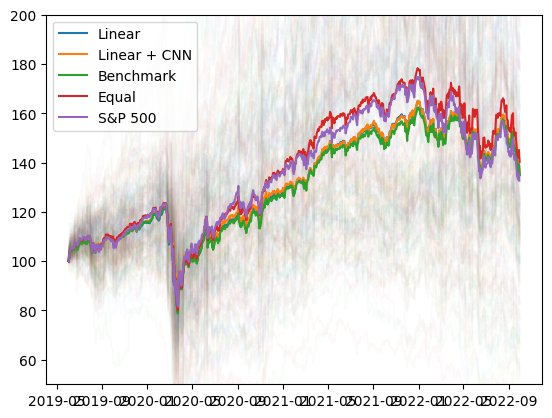

In [96]:
# Plots
plt.plot(prices_test, alpha=0.025)
# for model in ["Linear", "CNN", "Linear + CNN", "Benchmark", "Equal"]:
for model in ["Linear", "Linear + CNN", "Benchmark", "Equal"]:
    plt.plot(prices_test @ weights_hrp[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.legend();

In [97]:
for model in ["Linear", "CNN", "Linear + CNN", "Benchmark"]:
    print(model, "number of stocks included:", np.count_nonzero(weights_hrp[model]))

Linear number of stocks included: 200
CNN number of stocks included: 200
Linear + CNN number of stocks included: 200
Benchmark number of stocks included: 200
